In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random
from keras.layers import Activation, BatchNormalization
from tqdm import tqdm

In [ ]:
DATASET_NAME = 'colorectal_histology'

(training_set, validation_set), dataset_info = tfds.load(
    DATASET_NAME,
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteXE7M98/colorectal_histology-train.tfrecord


Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [ ]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train[:70%]'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['train[70%:]'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)


get_label_name = dataset_info.features['label'].int2str

Number of TRAIN examples: 3500
Number of TEST examples: 1500
Number of label classes: 8


In [ ]:
IMG_SHAPE = 128
IMG_SIZE = (IMG_SHAPE, IMG_SHAPE, 3)
categ = NUM_CLASSES

In [ ]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

In [ ]:
def format_example(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [IMG_SHAPE, IMG_SHAPE])
    return image, label

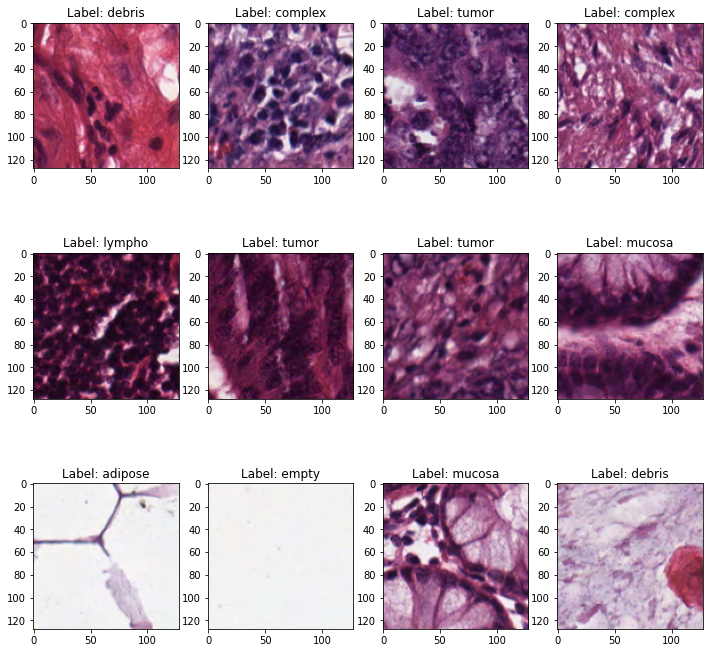

In [ ]:
BATCH_SIZE = 32
train_data = training_set.map(format_example)
test_data = validation_set.map(format_example)
preview_dataset(test_data)

In [ ]:
train_data = train_data.batch(
    batch_size=BATCH_SIZE
)

test_data = test_data.batch(
    batch_size=BATCH_SIZE
)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,AveragePooling2D
model=Sequential()

# Block 0
model.add(Conv2D(16,kernel_size=3,strides=1,padding="same",activation="relu", input_shape=IMG_SIZE))
# model.add(AveragePooling2D(padding="same"))
model.add(MaxPooling2D(padding="same"))

# Block 1
model.add(Conv2D(32,kernel_size=3,strides=1,padding="same",activation="relu"))
# model.add(AveragePooling2D(padding="same"))
model.add(MaxPooling2D(padding="same"))
model.add(Conv2D(32,kernel_size=5,strides=1,padding="same",activation="relu"))
# model.add(AveragePooling2D(padding="same"))
model.add(MaxPooling2D(padding="same"))

# Block 2
model.add(Conv2D(64,kernel_size=7,strides=1,padding="same",activation="relu"))
# model.add(AveragePooling2D(padding="same"))
model.add(MaxPooling2D(padding="same"))

# # Block 3
# model.add(Conv2D(64,kernel_size=7,strides=1,padding="same",activation="relu"))
# model.add(MaxPooling2D(padding="same"))

model.add(Flatten())


model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(categ, activation='softmax'))

model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        1

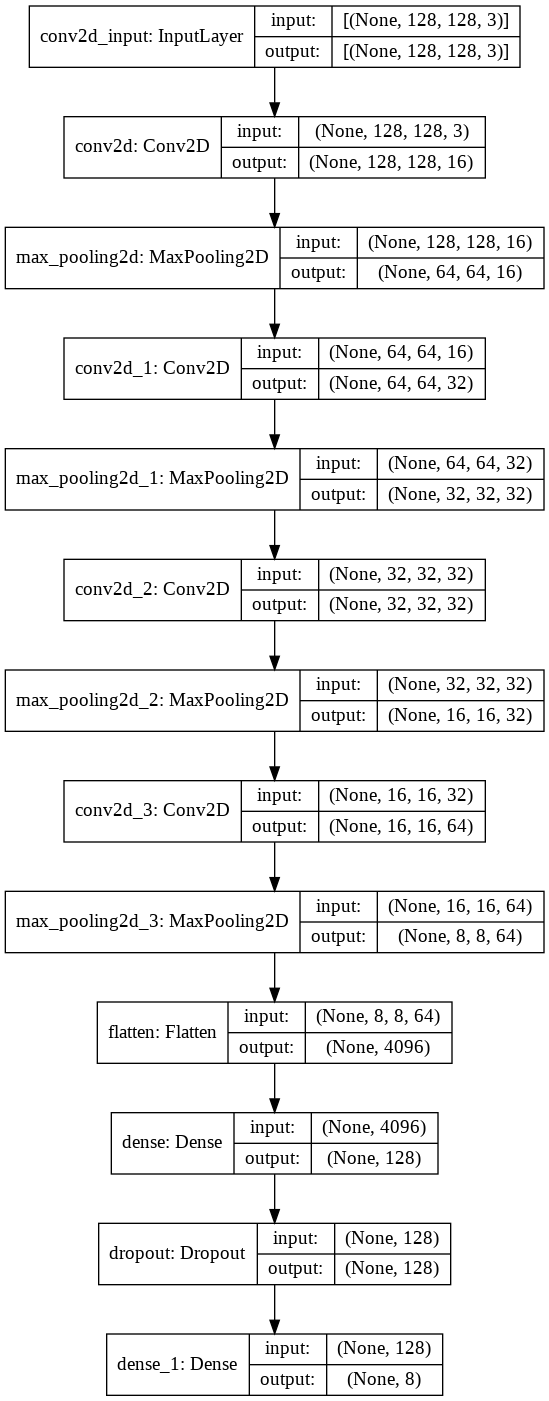

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 109
validation_steps: 46


In [ ]:
!rm -rf tmp/checkpoints
!rm -rf logs

In [ ]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_delta=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
history = model.fit(
    x=train_data.repeat(),
    validation_data=test_data.repeat(),
    callbacks=[lr_reduce, es_callback],
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/50
109/109 [==============================] - 39s 59ms/step - loss: 1.8105 - accuracy: 0.2456 - val_loss: 0.9870 - val_accuracy: 0.5598
Epoch 2/50
109/109 [==============================] - 6s 51ms/step - loss: 1.2087 - accuracy: 0.4528 - val_loss: 1.1206 - val_accuracy: 0.5543
Epoch 3/50
109/109 [==============================] - 6s 51ms/step - loss: 1.1076 - accuracy: 0.5322 - val_loss: 0.8925 - val_accuracy: 0.6005
Epoch 4/50
109/109 [==============================] - 6s 52ms/step - loss: 0.9187 - accuracy: 0.6368 - val_loss: 0.7694 - val_accuracy: 0.6495
Epoch 5/50
109/109 [==============================] - 6s 51ms/step - loss: 0.8517 - accuracy: 0.6472 - val_loss: 0.7317 - val_accuracy: 0.6984
Epoch 6/50
109/109 [==============================] - 6s 52ms/step - loss: 0.7572 - accuracy: 0.6930 - val_loss: 0.6574 - val_accuracy: 0.7323
Epoch 7/50
109/109 [==============================] - 6s 53ms/step - loss: 0.6962 - accuracy: 0.7260 - val_loss: 0.6821 - val_accuracy: 0.699

47/47 [==============================] - 2s 36ms/step - loss: 0.4713 - accuracy: 0.8467


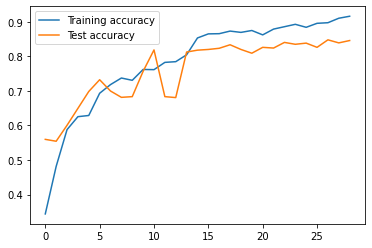

In [ ]:
model.evaluate(test_data)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.legend();



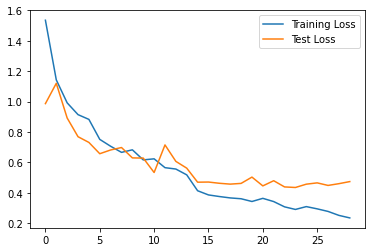

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();